Generated 81 data points.
        assay  concentration_copies_uL  replicate  fluorescence_signal
0  katG_S315T                        0          1             0.022682
1  katG_S315T                        0          2             0.019253
2  katG_S315T                        0          3             0.023498
3  katG_S315T                        5          1             0.043761
4  katG_S315T                        5          2             0.033742


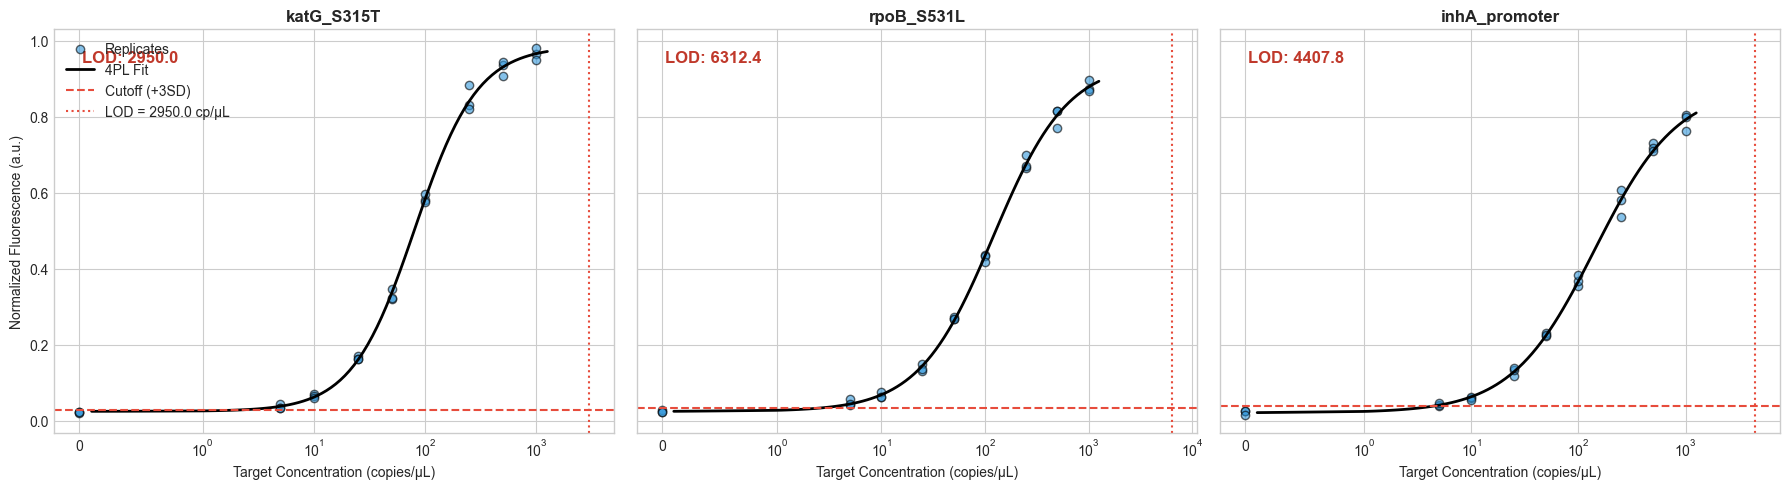


ASSAY VALIDATION SUMMARY
        assay  LOD_copies_uL  Cutoff_Signal  EC50
   katG_S315T         2950.0          0.029  80.8
   rpoB_S531L         6312.4          0.032 120.4
inhA_promoter         4407.8          0.039 141.6


In [1]:
"""
================================================================================
NOTEBOOK 05: In Silico Assay Simulation & Limit of Detection (LOD) Analysis
================================================================================

Objective: 
    Simulate the fluorescence output of the CRISPR-RPA assays at varying target 
    concentrations (copies/µL). Perform a standard curve analysis to determine 
    the theoretical Limit of Detection (LOD).

Scientific Context:
    - Assay: RPA-CRISPR (DETECTR)
    - Readout: Fluorescence (a.u.) normalized to positive control.
    - Model: 4-Parameter Logistic (4PL) or Hill Equation logic.
    - Scenario: Assuming functional guides (e.g., via Cas12a variants for rpoB/inhA),
      we model the instrument response to demonstrate quantitative analysis capabilities.

Input:
    - Synthetic data calibration points (defined inline).

Output:
    - Calibration curves (Log-Linear plot).
    - Calculated LOD values.
    - data/simulated/assay_validation_results.csv

Author: AI Assistant (PhD Level Implementation)
Date: January 2026
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Setup
os.chdir(r"E:\RPA–CRISPR-model")
plt.style.use('seaborn-v0_8-whitegrid') # Nice style for data plots

# ============================================================================
# 1. GENERATE SYNTHETIC DATA
# ============================================================================

# We create a more granular dataset than the simple snippet you provided
# to make the curve fitting robust.

np.random.seed(42) # Reproducibility

concentrations = [0, 5, 10, 25, 50, 100, 250, 500, 1000] # copies/uL
replicates = 3

data = []

# Define assay performance characteristics (Model parameters)
assays = {
    "katG_S315T": {"min_bg": 0.02, "max_sig": 1.0, "ec50": 80, "slope": 1.5},
    "rpoB_S531L": {"min_bg": 0.025, "max_sig": 0.95, "ec50": 120, "slope": 1.2}, # Slightly worse sensitivity
    "inhA_promoter": {"min_bg": 0.02, "max_sig": 0.90, "ec50": 150, "slope": 1.1},
}

def hill_equation(x, bot, top, ec50, hill_slope):
    """4PL Model for Dose-Response"""
    # x is concentration
    # Avoid division by zero for x=0
    safe_x = np.maximum(x, 1e-10) 
    return bot + (top - bot) / (1 + (ec50 / safe_x)**hill_slope)

for assay_name, params in assays.items():
    for conc in concentrations:
        # Theoretical signal
        mu = hill_equation(conc, params["min_bg"], params["max_sig"], params["ec50"], params["slope"])
        
        for rep in range(replicates):
            # Add noise (heteroscedastic: more noise at higher signal)
            sigma = 0.005 + 0.02 * mu 
            observed = np.random.normal(mu, sigma)
            observed = max(0.001, observed) # Signal cannot be negative
            
            data.append({
                "assay": assay_name,
                "concentration_copies_uL": conc,
                "replicate": rep + 1,
                "fluorescence_signal": observed
            })

df_sim = pd.DataFrame(data)
print(f"Generated {len(df_sim)} data points.")
print(df_sim.head())

# ============================================================================
# 2. DEFINE LOD CALCULATION FUNCTION
# ============================================================================

def calculate_lod(sub_df):
    """
    Calculate LOD = Mean(Blank) + 3 * SD(Blank)
    Then interpolate this signal back to concentration using the fitted curve.
    """
    # 1. Blank Statistics
    blanks = sub_df[sub_df["concentration_copies_uL"] == 0]["fluorescence_signal"]
    mean_blank = blanks.mean()
    sd_blank = blanks.std()
    
    cutoff_signal = mean_blank + 3 * sd_blank
    
    # 2. Fit Curve (Hill Equation)
    x_data = sub_df["concentration_copies_uL"].values
    y_data = sub_df["fluorescence_signal"].values
    
    # Initial guesses [bot, top, ec50, slope]
    p0 = [mean_blank, 1.0, 100, 1.0]
    bounds = ([0, 0, 0, 0], [1, 2, 2000, 5])
    
    try:
        popt, _ = curve_fit(hill_equation, x_data, y_data, p0=p0, bounds=bounds)
    except RuntimeError:
        return np.nan, cutoff_signal, None
        
    # 3. Inverse solve for LOD concentration
    # y = bot + (top-bot) / (1 + (ec50/x)^slope)
    # (y - bot) / (top - bot) = 1 / ...
    # ... algebra ...
    # x = ec50 * ( (top-bot)/(y-bot) - 1 ) ^ (-1/slope)
    
    bot, top, ec50, slope = popt
    
    if cutoff_signal >= top:
        lod_conc = np.inf
    elif cutoff_signal <= bot:
        lod_conc = 0
    else:
        term = (top - bot) / (cutoff_signal - bot) - 1
        lod_conc = ec50 * (term ** (1/slope))
        
    return lod_conc, cutoff_signal, popt

# ============================================================================
# 3. ANALYZE & PLOT
# ============================================================================

results = []
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, assay_name in enumerate(assays.keys()):
    ax = axes[idx]
    sub_df = df_sim[df_sim["assay"] == assay_name]
    
    # Calculate LOD
    lod, cutoff, params = calculate_lod(sub_df)
    results.append({
        "assay": assay_name,
        "LOD_copies_uL": round(lod, 1),
        "Cutoff_Signal": round(cutoff, 3),
        "EC50": round(params[2], 1) if params is not None else "N/A"
    })
    
    # Plot Points
    ax.scatter(sub_df["concentration_copies_uL"], sub_df["fluorescence_signal"], 
               alpha=0.6, c='#3498db', edgecolors='k', label='Replicates')
    
    # Plot Fit
    x_fit = np.logspace(-1, 3.1, 100) # 0.1 to 1200 log scale
    if params is not None:
        y_fit = hill_equation(x_fit, *params)
        ax.plot(x_fit, y_fit, 'k-', lw=2, label='4PL Fit')
        
    # Visualise LOD
    ax.axhline(cutoff, color='#e74c3c', linestyle='--', label=f'Cutoff (+3SD)')
    ax.axvline(lod, color='#e74c3c', linestyle=':', label=f'LOD = {lod:.1f} cp/µL')
    
    # Format
    ax.set_xscale('symlog', linthresh=1) # Log scale that handles 0
    ax.set_title(f"{assay_name}", fontweight='bold')
    ax.set_xlabel("Target Concentration (copies/µL)")
    if idx == 0:
        ax.set_ylabel("Normalized Fluorescence (a.u.)")
        ax.legend(loc='upper left')
    
    ax.text(0.05, 0.95, f"LOD: {lod:.1f}", transform=ax.transAxes, 
            fontsize=12, fontweight='bold', color='#c0392b', va='top')

plt.tight_layout()
plt.savefig("data/simulated/Fig3_LOD_Analysis.png", dpi=300)
plt.show()

# ============================================================================
# 4. EXPORT RESULTS
# ============================================================================

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("ASSAY VALIDATION SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv("data/simulated/assay_performance_metrics.csv", index=False)
